In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pickle
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [31]:
file = "../../data/raw/ENB2012_data.csv"
df = pd.read_csv(file)
X = df.drop(columns=['Y1', 'Y2'], axis=1)
y1 = df['Y1']
y2 = df['Y2']
dict_names = {
    'X1' : 'Compactnesss', 
    'X2' : 'Surface area', 
    'X3' : 'Wall area', 
    'X4' : 'Roof area', 
    'X5' : 'Overall height', 
    'X6' : 'Orientation', 
    'X7' : 'Glazing area', 
    'X8' : 'Area distribution',
    'Y1' : 'Heating load',     
    'Y2' : 'Cooling load',     
}

In [13]:
cat_ftrs = ['X6','X8']
num_ftrs = ['X1','X2','X3','X4','X5','X7']
target_ftrs = ['Y1', 'Y2']

## MinMaxScaler for num_ftrs
scaler = MinMaxScaler()
num_transformer = make_pipeline(scaler)
## One-hot encoding for cat_ftrs
ohe = OneHotEncoder(sparse=False, categories="auto")
cat_transformer = make_pipeline(ohe)

## Create a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_ftrs),
    ('cat', cat_transformer, cat_ftrs)
])

In [16]:
def ML_pipeline_GridSearchCV_kfold(X, y, seed, n_folds, 
                                 reg, param_grid):
    ## reg: the regressor
    ## param_grid: hyperparameters to be tuned
    X_other, X_test, y_other, y_test = train_test_split(X, y, 
                   test_size=0.2, random_state=seed)
    kf = KFold(n_splits=n_folds) # no need to shuffle again
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', reg)])
    grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1,
                        cv=kf, iid=False, scoring=\
        make_scorer(r2_score))
#         make_scorer(mean_squared_error, greater_is_better=False))
    grid.fit(X_other, y_other)
    return grid, X_test, y_test

### RandomForest regression

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rfr = RandomForestRegressor(random_state=42, n_estimators=20)
max_depths = [int(x) for x in np.linspace(2, 50, num=10)]
min_samples_splits = range(2, 12, 2)
param_grid_rfr = { "regressor__max_depth" : max_depths, 
               "regressor__min_samples_split" : min_samples_splits }
# Y1
grid, X_test, y_test = ML_pipeline_GridSearchCV_kfold(X, y1, 
      seed=42, n_folds=5, reg=rfr, param_grid=param_grid_rfr)
# Y2
grid_2, X_test_2, y_test_2 = ML_pipeline_GridSearchCV_kfold(X, y2, 
      seed=42, n_folds=5, reg=rfr, param_grid=param_grid_rfr)

In [27]:
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
file = open('../../results/randomforestregressor_grid_Y1.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

0.9971031215158795
0.9975128256079665
{'regressor__max_depth': 7, 'regressor__min_samples_split': 2}


In [28]:
print(grid_2.best_score_)
print(grid_2.score(X_test_2,y_test_2))
print(grid_2.best_params_)

# save the output so I can use it later
file = open('../../results/randomforestregressor_grid_Y2.save', 'wb')
pickle.dump((grid_2,X_test_2,y_test_2),file)
file.close()

0.9643540848898413
0.9600032734932054
{'regressor__max_depth': 7, 'regressor__min_samples_split': 2}


In [45]:
file = open('../../results/randomforestregressor_grid_Y1.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.9975128256079665
test baseline = 0
shuffling X1
   shuffled test score: 0.487 +/- 0.031
shuffling X2
   shuffled test score: 0.923 +/- 0.003
shuffling X3
   shuffled test score: 0.953 +/- 0.006
shuffling X4
   shuffled test score: 0.953 +/- 0.004
shuffling X5
   shuffled test score: 0.976 +/- 0.001
shuffling X6
   shuffled test score: 0.998 +/- 0.0
shuffling X7
   shuffled test score: 0.859 +/- 0.017
shuffling X8
   shuffled test score: 0.987 +/- 0.001


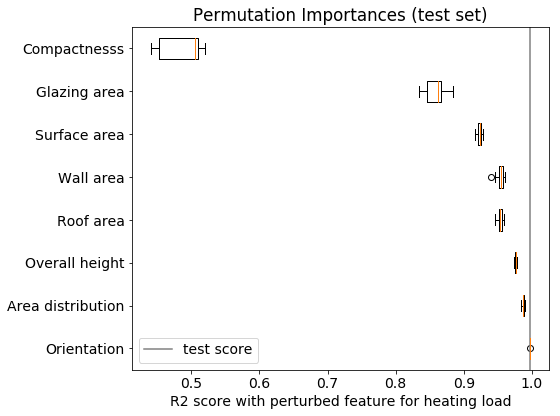

In [46]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
name_labels = [dict_names[ftr_names[_]] for _ in sorted_indcs]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=name_labels,vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature for heating load')
plt.legend()
plt.tight_layout()
plt.savefig("../../figures/Y1_gfi_permutation.pdf")
plt.show()

In [47]:
file = open('../../results/randomforestregressor_grid_Y2.save', 'rb')
grid_2, X_test_2, y_test_2 = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test_2.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid_2.score(X_test_2,y_test_2)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_2.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_2[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test_2))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.9600032734932054
test baseline = 0
shuffling X1
   shuffled test score: 0.425 +/- 0.038
shuffling X2
   shuffled test score: 0.839 +/- 0.009
shuffling X3
   shuffled test score: 0.866 +/- 0.008
shuffling X4
   shuffled test score: 0.868 +/- 0.005
shuffling X5
   shuffled test score: 0.889 +/- 0.003
shuffling X6
   shuffled test score: 0.897 +/- 0.001
shuffling X7
   shuffled test score: 0.803 +/- 0.012
shuffling X8
   shuffled test score: 0.901 +/- 0.004


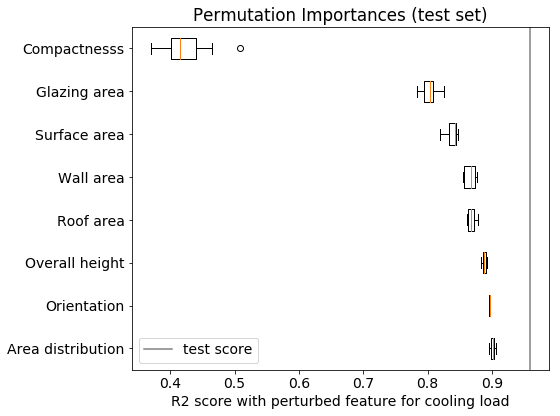

In [48]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
name_labels = [dict_names[ftr_names[_]] for _ in sorted_indcs]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=name_labels,vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature for cooling load')
plt.legend()
plt.tight_layout()
plt.savefig("../../figures/Y2_gfi_permutation.pdf")
plt.show()

In [50]:
import shap
shap.initjs() # required for visualizations later on

In [51]:
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
X_test_transformed = grid.best_estimator_[0].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)
print(np.shape(shap_values))

(154, 16)


In [52]:
# create the explainer object with the random forest model
explainer_2 = shap.TreeExplainer(grid_2.best_estimator_[1])
X_test_transformed_2 = grid_2.best_estimator_[0].transform(X_test_2)
shap_values_2 = explainer_2.shap_values(X_test_transformed_2)
print(np.shape(shap_values_2))

(154, 16)


In [53]:
print(X_test_transformed_2.shape)
feature_names =  num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))

(154, 16)


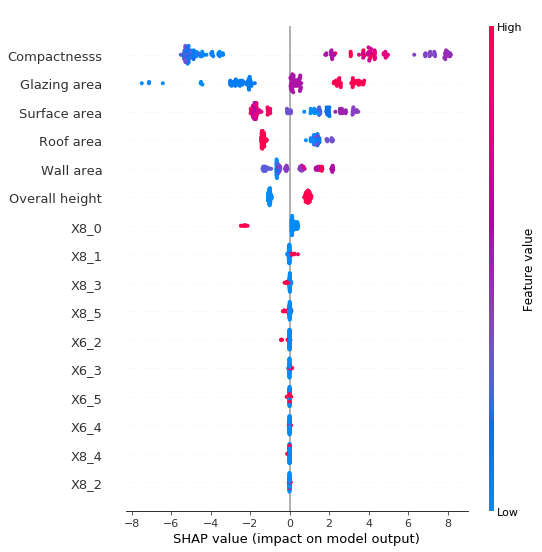

In [62]:
names = []
for _ in feature_names:
    if _ in dict_names.keys():
        names.append(dict_names[_])
    else:
        names.append(_)
shap.summary_plot(shap_values, X_test_transformed, feature_names=names, show=False)
plt.tight_layout()
plt.savefig("../../figures/shap_Y1_gfi.pdf")

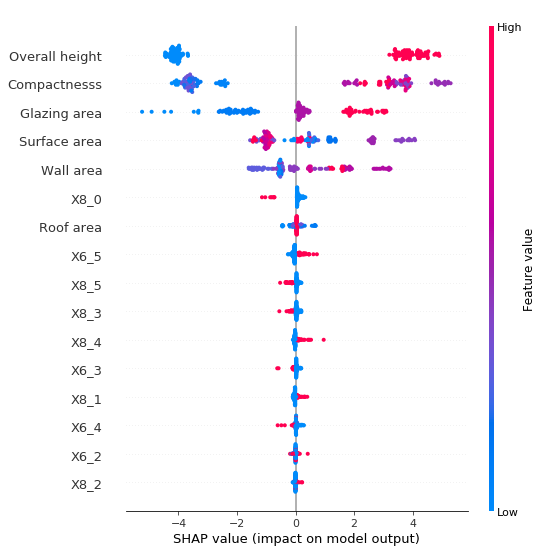

In [61]:
shap.summary_plot(shap_values_2, X_test_transformed_2, feature_names=names, show=False)
plt.tight_layout()
plt.savefig("../../figures/shap_Y2_gfi.pdf")

### Local feature importance

Chose a sinple point from the testing set to study the local feature importance

In [79]:
ind = 2
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_transformed[ind,:],
               feature_names = names)
# plt.savefig("../../figures/Y1_local_importance.pdf")

In [80]:
ind2 = 2
shap.force_plot(explainer_2.expected_value, shap_values_2[ind2,:], features=X_test_transformed_2[ind2,:],
               feature_names = names, show=False)
# plt.savefig("../../figures/Y2_local_importance.pdf")